# Homework 3

- Implement the ridge regression algorithm through a gradient descent algorithm
- apply it to a regression problem (with at least 10 predictors) for a chosen dataset
- optimize the choice of lambda with R^2 and cross-validation 
- check the accuracy of the final prediction on the test part of the data set.
- compare to a result of a simple linear regression fit
- comment on the results

In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy as sp

from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.metrics import r2_score, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import KFold


# to make this notebook's output stable across runs
np.random.seed(1)

In [4]:
%matplotlib inline

## Creating dataset (NOT USED)

Dataset is created as a linear function of predictors with added noise.

I used this dataset as initial dataset for building the model. It is a perfect dataset for Ridge Regression model, as it fits a linear model. My implementation reaches $r^2$ score of approximately $0.99...$, similar to models from SciKitLearn library.

In [5]:
num_predictors = 10
num_examples = 1000

In [6]:
beta_0 = np.random.rand()
betas = np.random.uniform(size=num_predictors) * 2 - 1

print(beta_0, betas)

0.417022004702574 [ 0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281 -0.62747958
 -0.30887855 -0.20646505  0.07763347 -0.16161097]


In [7]:
def get_y(x):
    return beta_0 + np.dot(betas, x.T)

In [8]:
predictor_means = np.random.uniform(size=[num_predictors])
predictor_stddevs = np.random.uniform(size=[num_predictors])
x = np.random.normal(size=[num_examples, num_predictors], loc=predictor_means, scale=predictor_stddevs)
y = get_y(x) + np.random.normal(size=[num_examples], scale=0.1)

In [9]:
print(x.shape)
print(y.shape)

(1000, 10)
(1000,)


## Loading existing dataset

In [10]:
data = pd.read_csv('./slump_test.csv')
y = data.iloc[:, -1].values
x = data.iloc[:, :-1].values
data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [12]:
np.amin(x, axis=0)

array([  1. , 137. ,   0. ,   0. , 160. ,   4.4, 708. , 640.6,   0. ,
        20. ])

In [13]:
np.amax(x, axis=0)

array([ 103. ,  374. ,  193. ,  260. ,  240. ,   19. , 1049.9,  902. ,
         29. ,   78. ])

## Model definition

In [14]:
class RidgeRegression:
    def __init__(self, alpha=0.0, learning_rate=0.01, normalize=True):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.normalize = normalize
        
    def normalize_x(self, x):
        if self.normalize:
            return (x - self.min_x) / (self.max_x - self.min_x)
        return x
    
    def normalize_y(self, y):
        if self.normalize:
            return (y - self.min_y) / (self.max_y - self.min_y)
        return x
    
    def denormalize_y(self, y_norm):
        if self.normalize:
            return y_norm * (self.max_y - self.min_y) + self.min_y
        return y_norm
    
    def gradient_descent_step(self, x, y):
        errors = y - (self.beta_0 + np.sum(x * self.beta, axis=1))
        d_beta_0 = -2 * np.mean(errors)
        d_beta = -2 * np.dot(x.T, errors) / len(x) + 2 * self.alpha * self.beta
        self.beta_0 -= self.learning_rate * d_beta_0
        self.beta -= self.learning_rate * d_beta
        
    def fit(self, x, y, epochs=100):
        self.beta_0 = np.random.normal()
        self.beta = np.random.normal(size=x.shape[1])
        
        self.min_x, self.max_x = np.amin(x, axis=0), np.amax(x, axis=0)
        self.min_y, self.max_y = np.amin(y, axis=0), np.amax(y, axis=0)
        
        x = self.normalize_x(x)
        y = self.normalize_y(y)
        
#         x_mean = np.mean(x, axis=0)
#         x_wave = x / np.mean(np.power(x - x_mean, 2), axis=0)
        
        for e in range(epochs):
            self.gradient_descent_step(x, y);
            
    def predict(self, x):
        x = self.normalize_x(x)
        result = self.beta_0 + np.sum(x * self.beta, axis=1)
        return self.denormalize_y(result)
    
    def score(self, x, y):
        return r2_score(y, self.predict(x))

## Cross validation

In [15]:
# Run for different values of lambda 
lambda_min = -4
lambda_max = 1
num_lambdas = 15
lambdas = np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

In [16]:
kfold = KFold(n_splits=5, random_state=123)

for ind, i in enumerate(lambdas):
    reg = RidgeRegression(alpha=10**i, learning_rate=0.01)
    
    train = []
    test = []
    for train_idx, test_idx in kfold.split(x):
        reg.fit(x[train_idx], y[train_idx], epochs=10000)
        train.append(reg.score(x[train_idx], y[train_idx]))
        test.append(reg.score(x[test_idx], y[test_idx]))
    print(np.array(train))
    print(np.array(test))
    print('-----')
    # Evaluate train & test performance
    train_r_squared[ind] = np.mean(train)
    test_r_squared[ind] = np.mean(test)

[0.91671815 0.89873251 0.89522864 0.88304197 0.85889735]
[0.72360397 0.91116215 0.90432748 0.69623088 0.41356519]
-----
[0.90546017 0.88958071 0.9037693  0.91071039 0.89770671]
[0.74834054 0.91129093 0.88493468 0.83450642 0.84072919]
-----
[0.88596446 0.83135601 0.89504047 0.91214543 0.86594646]
[0.76167875 0.84418095 0.89824235 0.85929721 0.70754492]
-----
[0.90698605 0.83642799 0.9069781  0.88888997 0.88815103]
[0.78155443 0.85472049 0.8894883  0.79721319 0.89421353]
-----
[0.91788353 0.90225798 0.90723724 0.89594064 0.89930427]
[0.77636467 0.91123583 0.88074239 0.83592508 0.86998338]
-----
[0.89425911 0.88303898 0.89933662 0.89931952 0.88880855]
[0.76910011 0.90524556 0.86529824 0.85137565 0.88494337]
-----
[0.88994254 0.85621603 0.86820599 0.87327257 0.85495415]
[0.71928004 0.84837618 0.81171484 0.80053861 0.80772228]
-----
[0.82197254 0.77789564 0.79062333 0.80474309 0.77402068]
[0.59538379 0.72637844 0.72467307 0.63329517 0.61390991]
-----
[0.69225044 0.63665691 0.640154   0.6750

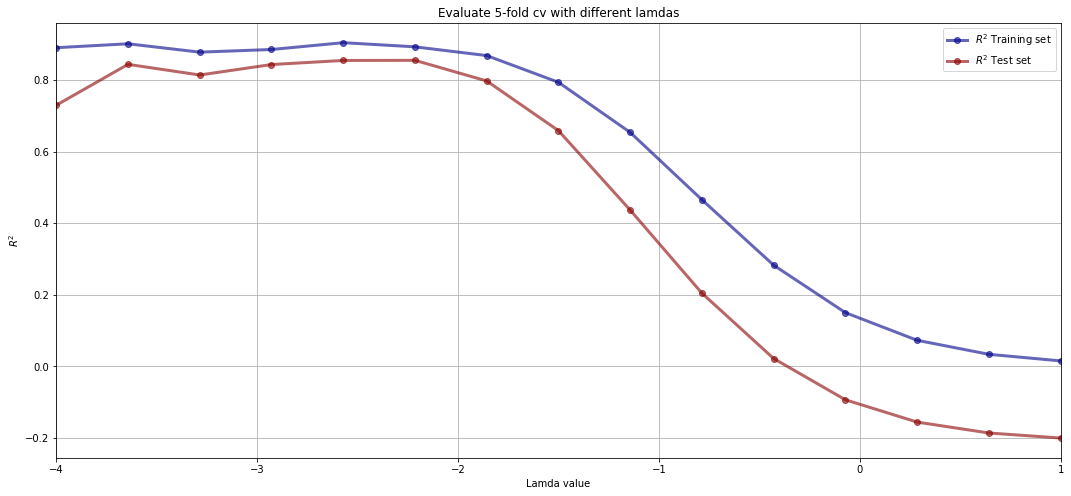

In [17]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(lambdas, train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(lambdas, test_r_squared,  'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(lambda_min, lambda_max)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

## Selecting the best $\lambda$ value

Low $\lambda$ values seem to result in highest $r^2$ score

In [18]:
m = RidgeRegression(alpha=0.005, learning_rate=0.01)

In [19]:
m.fit(x_train, y_train, epochs=10000)

In [20]:
y_p = m.predict(x_test)

### Computed betas

In [21]:
print(m.beta_0)
print(m.beta)

0.23984864319633406
[-0.02742707  0.4748021   0.02026426  0.42890702 -0.25237528 -0.00297546
 -0.12496776 -0.00477181 -0.13769006  0.07727684]


### Accuracy

In [22]:
r2_score(y_test, y_p)

0.8602092932597064

## Compare to Linear Regression

In [24]:
lin = Lin_Reg()
lin.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
y_lin = lin.predict(x_test)

### Accuracy

In [26]:
r2_score(y_test, y_lin)

0.8435454185116431

### Conclusions
Both models get very similar results.

The model gets the best results with $\lambda$ smaller that $0.05$. For higher $\lambda$ values, the shrinkage penalty on $\beta_i$ becomes dominant component of the loss function. This results in assigning lower values to $\beta_i$, which in turn results in incorrect predictions of $y_i$